In [3]:
#Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [4]:
#fetching the data
data = pd.read_csv('C:\\Users\\ccuti\\Data Science\\Project\\Game Winner Predication\\data\\pubg.csv')

In [5]:
#getting informtaion regarding float, int or object type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [6]:
#checking for missing values
null = data.isnull().sum()
null
# we can see that there is one missing value in WinPlacePerc so we will drop it

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [7]:
data[data.winPlacePerc.isnull()]
data.drop(2744604,inplace=True)


# winPlacePerc - Parameters

Let's talk about availabe feature in the given PubG Data.

Data fields

DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

Text(0.5, 1.0, 'kills for different matches')

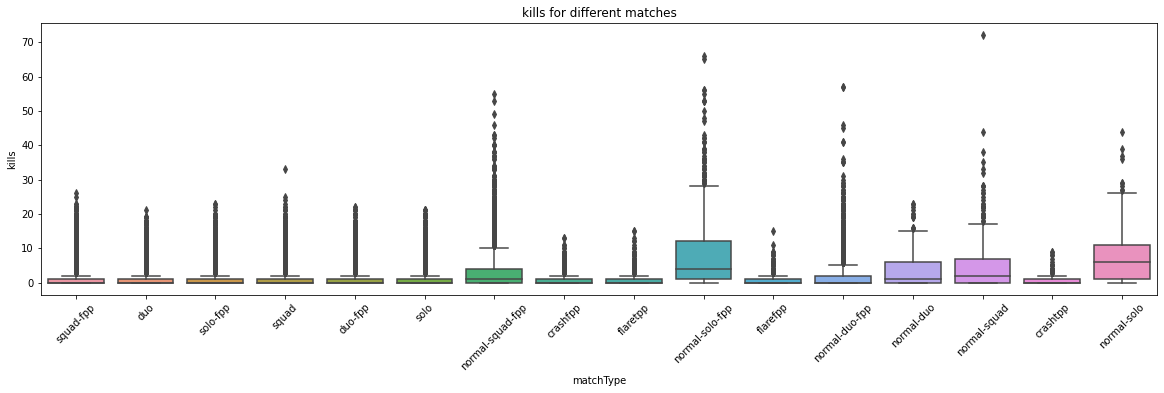

In [8]:
#Plotting box plot between different match type and kills
fig, axes = plt.subplots(figsize=(20,5))
sns.boxplot(y='kills', x='matchType', data=data, ax= axes)
plt.xticks(rotation=45)
plt.title('kills for different matches')

Text(0.5, 1.0, 'Frequecy of different types of match')

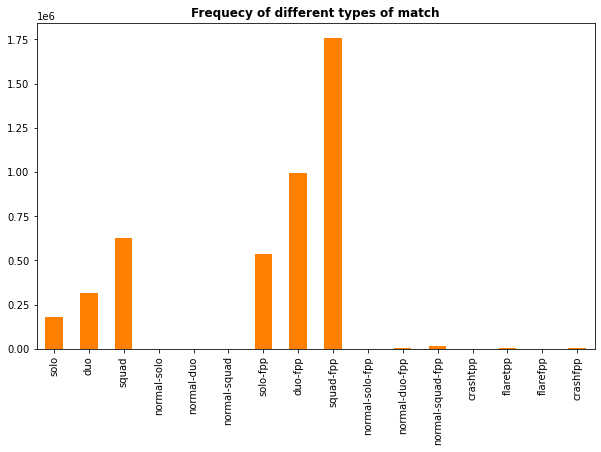

In [9]:
# Frequecy of different types of match
matchTypes = ["solo", "duo", "squad", "normal-solo", "normal-duo", "normal-squad", "solo-fpp", "duo-fpp", "squad-fpp", "normal-solo-fpp", "normal-duo-fpp", "normal-squad-fpp", "crashtpp", "flaretpp", "flarefpp", "crashfpp"]
data["matchType"].value_counts()[matchTypes].plot(kind="bar", figsize=(10,6), color="#ff8000")
plt.title("Frequecy of different types of match", fontweight="bold")

We can see that there are many outliers when it comes to the number of kills.
So let us analyse the kills with respect to the distance traveled

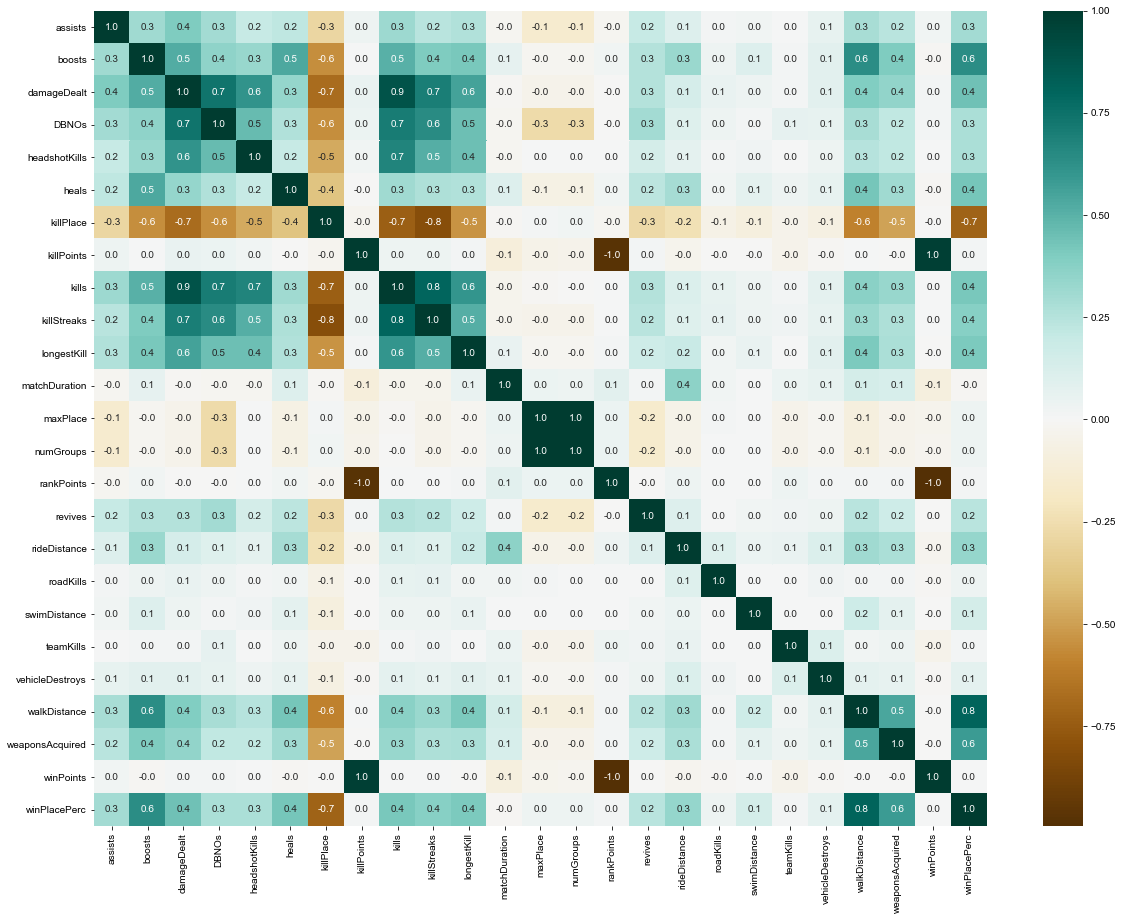

In [10]:
#Checking the correlation between all the attributes
corr = data.corr()
f,ax = plt.subplots(figsize=(20, 15))
sns.heatmap(data.corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

winPlacePerc is our to be predicted value. The features with the highest linear correlation are
walkDistance (0.81) killPlace (-0.71) boosts (0.62) weaponsAcquired (0.57) damageDealt (0.44)


# Outliers

1) checking for distance and total distance with respect to number of kills

In [11]:
#Analysing the walk distance traveled, there are 3 ways to do so
#rideDistance
#walkDistance
#swimDistance
data['total_distance']=data.rideDistance+data.walkDistance+data.swimDistance
print(data.total_distance)

0           244.8000
1          1445.0445
2           161.8000
3           202.7000
4            49.7500
             ...    
4446961    2311.0000
4446962      81.7000
4446963     790.8840
4446964    2748.0000
4446965    2613.0000
Name: total_distance, Length: 4446965, dtype: float64


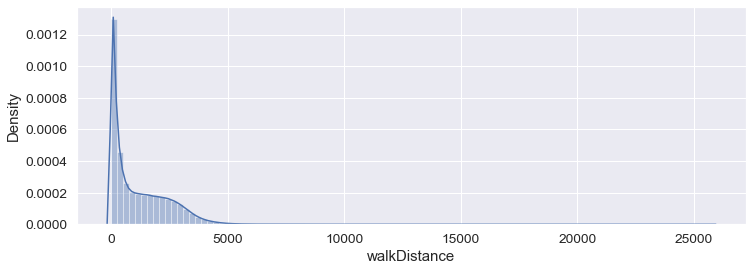

(219, 30)

In [12]:
#Walk Distance
plt.figure(figsize=(12,4))
sns.distplot(data['walkDistance'], bins=100)
plt.show()

data[data['walkDistance']>=10000].shape

In [13]:
#walk distance greater that 1km (10000m) will be dropped
data.drop(data[data['walkDistance']>=10000].index,inplace=True)

(138, 30)

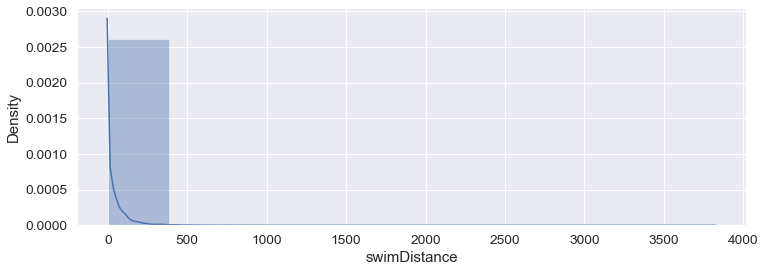

In [14]:
#Swim distance
plt.subplots(figsize=(12, 4))
sns.distplot(data.swimDistance,bins=10)

data[data['swimDistance']>=1000].shape

In [15]:
#swin distance greater than 1000m will be dropped
data.drop(data[data['swimDistance']>=1000].index,inplace=True)


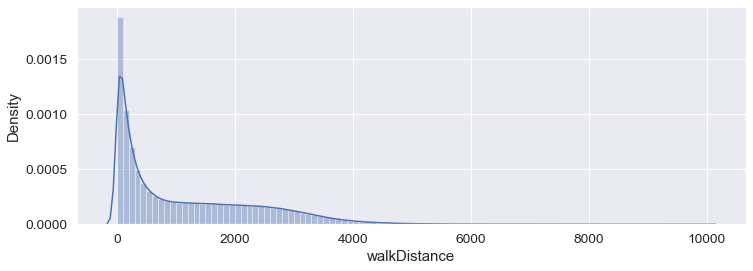

(498, 30)

In [16]:
#riding distance
plt.figure(figsize=(12,4))
sns.distplot(data['walkDistance'], bins=100)
plt.show()

data[data['rideDistance']>=15000].shape




In [19]:
data.drop(data[data['rideDistance']>15000].index, inplace=True)

1.1 Kills with respect to total distance travelled

In [20]:
# checking for kills without moving
data['killsWithoutMoving'] = ((data['kills'] > 0) & (data['total_distance'] == 0))
# find the count.
data['killsWithoutMoving'].value_counts()


False    4444576
True        1535
Name: killsWithoutMoving, dtype: int64

In [21]:
#dropping those values
data.drop(data[data['killsWithoutMoving'] == True].index, inplace=True)

2) Checking with respect to Roadkills

In [22]:
#checking value_counts for Roadkills

data['roadKills'].value_counts()

0     4431617
1       11215
2        1293
3         297
4          72
5          36
6          20
7          11
8           7
9           2
10          2
11          2
14          1
18          1
Name: roadKills, dtype: int64

In [23]:
#the roadlkills usually between 0-13, thus above that are the anomalies which will be dropped
data.drop(data[data['roadKills']>=10].index,inplace=True)


3) Total Kills

In [24]:
data['kills'].value_counts()

0     2529158
1      927505
2      472225
3      232238
4      124397
5       66475
6       37861
7       21739
8       12713
9        7580
10       4562
11       2756
12       1726
13       1107
14        742
15        468
16        319
17        225
18        159
19        105
20         94
22         74
21         61
23         40
24         39
25         24
26         24
28         22
27         15
33         12
31         11
29         11
30         11
35          6
36          6
38          6
41          5
34          5
37          5
32          4
53          4
40          4
39          4
42          3
55          2
43          2
44          2
46          2
57          2
56          2
66          1
65          1
45          1
50          1
49          1
48          1
47          1
72          1
Name: kills, dtype: int64

In [25]:
#Anomalies above 35 kills will be droppped
data.drop(data[data['kills']>=35].index,inplace=True)

4) with respect to weapons aquired

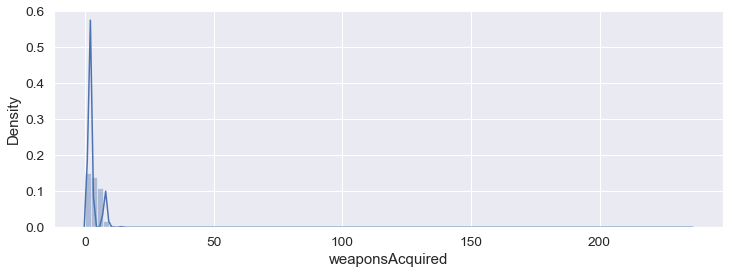

In [26]:
plt.figure(figsize=(12,4))
sns.distplot(data['weaponsAcquired'], bins=100)
plt.show()


In [27]:
data[data.weaponsAcquired>=50].shape

(137, 31)

In [28]:
data.drop(data[data.weaponsAcquired>=50].index,inplace=True)

5) With respect to heals

In [ ]:
plt.subplots(figsize=(12,4))
sns.distplot(data.heals, bins=20)

data[data.heals>=40].shape


In [30]:
data.drop(data[data.heals>=40].index, inplace = True)

# Dealing with Categorical Variables


In [31]:
print(data.select_dtypes(include='object').describe().columns.tolist())

['Id', 'groupId', 'matchId', 'matchType']


In [32]:
#We will one hot encode the 'matchType' feature to use it in our Random Forest model.
#One hot encode matchType
data = pd.get_dummies(data, columns=['matchType'])

#result of encoding
matchType_encoding = data.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


There are a lot of groupId's and matchId's so one-hot encoding them is computational suicide. We will turn them into category codes. That way we can still benefit from correlations between groups and matches in our Random Forest algorithm.

In [33]:
# Turning groupId and match Id into categorical types
data['groupId'] = data['groupId'].astype('category')
data['matchId'] = data['matchId'].astype('category')

# Getting category coding for groupId and matchID
data['groupId_cat'] = data['groupId'].cat.codes
data['matchId_cat'] = data['matchId'].cat.codes

# Getting rid of old columns
data.drop(columns=['groupId', 'matchId'], inplace=True)


In [34]:
#storing the ID in a diff data as it wont be useful for training model, which will be used later while prediction
data_id=data['Id']

In [35]:
#dropping unnecessary columns which are present and which were created for finding outliers

data.drop(columns=['killsWithoutMoving', 'total_distance', 'Id'], inplace=True)

# Model

In [36]:
#splitting the dataset
x = data.drop(['winPlacePerc'],axis=1)
y = data['winPlacePerc']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 2020)


accuracy_score(y_test, y_test_pred)
print("Test Set Accuracy:"+str(accuracy_score(y_test_pred,y_test)*100))

In [52]:
#Simple Logistic regression model with scaled features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,confusion_matrix,mean_absolute_error

model_lr = LinearRegression()
model_lr.fit(x_train,y_train)
y_train_pred = model_lr.predict(x_train)
y_test_pred = model_lr.predict(x_test)
scoring = mean_absolute_error(y_test_pred, y_test)
r2=r2_score(y_test_pred, y_test)
print(scoring,r2)

0.08953540616544631 0.8114234617997216


In [112]:
#random forest regressor y_test, y_test_pred
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
model.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

In [124]:
print('mae train: ', mean_absolute_error(model.predict(x_train), y_train))

mae train:  0.041444613776130027


In [148]:
pred = model.predict(x_test)
print('mae train: ', mean_absolute_error(pred, y_test))

mae train:  0.06051742195135688


In [154]:
output = pd.DataFrame({'Id':data_id[:3555388],'winPlacePerc':y_train_pred*100})
output

,Id,winPlacePerc
0,7f96b2f878858a,29.567227
1,eef90569b9d03c,16.854345
2,1eaf90ac73de72,60.873328
3,4616d365dd2853,68.463676
4,315c96c26c9aac,37.964537
...,...,...
3557580,ec2c5c9b926ee6,50.183217
3557581,3e55a4325c1bb6,5.970281
3557582,44a28b4a2d9956,4.105934
3557583,4492e911379dab,1.702615


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3555388 entries, 2931253 to 1766889
Data columns (total 42 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   assists                     int64  
 1   boosts                      int64  
 2   damageDealt                 float64
 3   DBNOs                       int64  
 4   headshotKills               int64  
 5   heals                       int64  
 6   killPlace                   int64  
 7   killPoints                  int64  
 8   kills                       int64  
 9   killStreaks                 int64  
 10  longestKill                 float64
 11  matchDuration               int64  
 12  maxPlace                    int64  
 13  numGroups                   int64  
 14  rankPoints                  int64  
 15  revives                     int64  
 16  rideDistance                float64
 17  roadKills                   int64  
 18  swimDistance                float64
 19  teamKills      